# Exercise 2
    Find all the mentions of world countries in the whole corpus, using the pycountry utility (HINT: remember that there will be different surface forms for the same country in the text, e.g., Switzerland, switzerland, CH, etc.) Perform sentiment analysis on every email message using the demo methods in the nltk.sentiment.util module. Aggregate the polarity information of all the emails by country, and plot a histogram (ordered and colored by polarity level) that summarizes the perception of the different countries. Repeat the aggregation + plotting steps using different demo methods from the sentiment analysis module -- can you find substantial differences?

In [38]:
from os import path
from collections import Counter
import pycountry
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.sentiment.util import demo_subjectivity
from functools import reduce
import numpy as np
%matplotlib inline

In [3]:
# Read the csv file
print('Reading csv file...')
df = pd.read_csv(path.join('hillary-clinton-emails', 'emails.csv'))
print('is done!')

Reading csv file...
is done!


### Data
For this part, we only use the extracted body column. For instance, consider the case when Clinton replied to an email. The raw text contains all messages between them; however, the extracted body column contains only her reply. Hence, it makes sense to only consider the extracted body column to perform sentiment analysis of Hilary Clinton's comments.

In [10]:
raw_text = df['ExtractedBodyText'].dropna().reset_index(drop=True)

### Text cleaning
Cleaning the raw text is also crucial for further analysis. We use the following function to clean the raw text.

In [13]:
def text_cleaning(text):
    # Convert all words to lower case
    text = text.lower()    
    # Tokenize the text while removing all words with less than 3 characters
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w{3,}')
    token_text = tokenizer.tokenize(text)
    # Remove common words from the text
    s = set(nltk.corpus.stopwords.words('english'))
    token_text = list(filter(lambda x: x not in s, token_text))
    return ' '.join(token_text)

In [14]:
clean_text = raw_text.map(text_cleaning)

### Sentiment analysis
Now we perform the sentiment intensity analyzer using polarity score criteria on the clean text. We also use 2 different sentiment analyzer using from different demo modules.

In [20]:
sentim_analyzer = SentimentIntensityAnalyzer()
plr_scores = clean_text.map(sentim_analyzer.polarity_scores)
compound_scores = plr_scores.map(lambda x: x['compound'])

#### 1. demo_liu_hu_lexicon:
Basic example of sentiment classification using Liu and Hu opinion lexicon. This function simply counts the number of positive, negative and neutral words in the sentence and classifies it depending on which polarity is more represented. Words that do not appear in the lexicon are considered as neutral. However, demo files can only print the results. Thus, we define a new function to store the results. The code is identical to NLTK sentiment codes available [here](http://www.nltk.org/_modules/nltk/sentiment/util.html).

In [21]:
def demo_liu_hu_lexicon(sentence):
    """
    Basic example of sentiment classification using Liu and Hu opinion lexicon.
    This function simply counts the number of positive, negative and neutral words
    in the sentence and classifies it depending on which polarity is more represented.
    Words that do not appear in the lexicon are considered as neutral.

    :param sentence: a sentence whose polarity has to be classified.
    :param plot: if True, plot a visual representation of the sentence polarity.
    """
    from nltk.corpus import opinion_lexicon
    from nltk.tokenize import treebank

    tokenizer = treebank.TreebankWordTokenizer()
    pos_words = 0
    neg_words = 0
    tokenized_sent = [word.lower() for word in tokenizer.tokenize(sentence)]

    x = list(range(len(tokenized_sent))) # x axis for the plot
    y = []

    for word in tokenized_sent:
        if word in opinion_lexicon.positive():
            pos_words += 1
            y.append(1) # positive
        elif word in opinion_lexicon.negative():
            neg_words += 1
            y.append(-1) # negative
        else:
            y.append(0) # neutral
    
    if pos_words > neg_words:
        output = 'Positive'
    elif pos_words < neg_words:
        output = 'Negative'
    elif pos_words == neg_words:
        output = 'Neutral'
    return output

In [22]:
liu_hu_scores = clean_text.map(demo_liu_hu_lexicon)

#### 2. demo_sent_subjectivity:
Classify a single sentence as subjective or objective using a stored SentimentAnalyzer. Similar to the previous demo function, it can only print the results. Thus, we define a new function to store the results. The code is identical to NLTK sentiment codes available [here](http://www.nltk.org/_modules/nltk/sentiment/util.html).

In [28]:
def demo_sent_subjectivity(text):

    from nltk.classify import NaiveBayesClassifier
    from nltk.tokenize import regexp
    from nltk.data import load
    word_tokenizer = regexp.WhitespaceTokenizer()
    try:
        sentim_analyzer = load('sa_subjectivity.pickle')
    except LookupError:
        print('Cannot find the sentiment analyzer you want to load.')
        print('Training a new one using NaiveBayesClassifier.')
        sentim_analyzer = demo_subjectivity(NaiveBayesClassifier.train, True)

    # Tokenize and convert to lower case
    tokenized_text = [word.lower() for word in word_tokenizer.tokenize(text)]
    return sentim_analyzer.classify(tokenized_text)

In [29]:
sent_sub_scores = clean_text.map(demo_sent_subjectivity)

Cannot find the sentiment analyzer you want to load.
Training a new one using NaiveBayesClassifier.
Training classifier
Most Informative Features
            contains(--) = True             subj : obj    =     61.0 : 1.0
        contains(film's) = True             subj : obj    =     33.7 : 1.0
       contains(decides) = True              obj : subj   =     28.3 : 1.0
      contains(discover) = True              obj : subj   =     26.3 : 1.0
    contains(girlfriend) = True              obj : subj   =     25.0 : 1.0
          contains(town) = True              obj : subj   =     23.4 : 1.0
  contains(entertaining) = True             subj : obj    =     22.2 : 1.0
     contains(detective) = True              obj : subj   =     21.0 : 1.0
        contains(mother) = True              obj : subj   =     20.1 : 1.0
         contains(finds) = True              obj : subj   =     19.9 : 1.0
Evaluating NaiveBayesClassifier results...
Saving sa_subjectivity.pickle


### Countries mentioned in emails
In this section, we find all countries which are mentioned in each email.

In [30]:
countries_dict = {country.alpha_2: [country.alpha_2.lower(),
                                    country.alpha_3.lower(),
                                    country.name.split(",")[0].lower()]
                  for country in pycountry.countries}

Some countries names are still complex which should be shortened or modified. We add the following elements to our dictionary.

In [31]:
countries_dict['GB'].extend(['uk', 'united kingdom', 'great britain'])
countries_dict['US'].extend(['u.s.', 'u.s.a'])
countries_dict['RU'].append('russia')
countries_dict['KP'].append('north korea')
countries_dict['KR'].append('south korea')
countries_dict['SY'].append('syria')

Some words in country alpha_2 and alpha_3 are misleading, e.g., are, pm, re, etc. We should exclude all these words from searching!

In [32]:
excluded_words = ['am', 'as', 'at', 'bf', 'cc', 'cv', 'ee', 'eh', 'gf', 'gg', 'id', 'co'
                  'ie', 'im', 'in', 'is', 'it', 'no', 'np', 'pm', 'tf', 'to', 'us',
                  'arm', 'can', 'com', 'col', 'mac', 'and', 'are', 'ago']

In [33]:
def search_for_countries(text):
    result = []
    for key, values in countries_dict.items():
        for value in values:
            if len(value.split()) == 1:
                if (value in text.split()) and (value not in excluded_words):
                    result.append(key)
                    break
                else:
                    pass
            else:
                if value in text:
                    result.append(key)
                    break
                else:
                    pass
    return result

In [34]:
countries_lst = clean_text.map(search_for_countries)

### Plot the results!

In [39]:
# Falttening the list
all_countires = reduce(lambda x,y: x+y,countries_lst)
# Calculating the frequency of the countires
counts = np.asarray(list(map(lambda x:all_countires.count(x),list(countries_dict.keys()))))

calculating the average score among the emails

In [44]:
def avg_score(scores_emails):
    scores = np.zeros(len(counts))
    for i,country_name in enumerate(list(countries_dict.keys())):
        for j,country in enumerate(countries_lst):
            if country_name in country:
                scores[i] += scores_emails[j]
    average_score = scores/(counts+1*(counts==0))
    return average_score

#### Compound Score

In [126]:
average_polar = avg_score(compound_scores)

In [127]:
data_country = pd.DataFrame({'name':list(countries_dict.keys())})
data_country['count'] = counts
data_country['polar'] = average_polar
data_country = data_country.sort(['polar'])
data_country = data_country.set_index(['name'])

/Users/salehi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


We decide to keep only the countries who have more than 30 entries

In [128]:
data_country_frequent = data_country[data_country['count']>30]
data_country_frequent_compound = data_country_frequent

(array([   0.,   20.,   40.,   60.,   80.,  100.,  120.,  140.,  160.,  180.]),
 <a list of 10 Text yticklabel objects>)

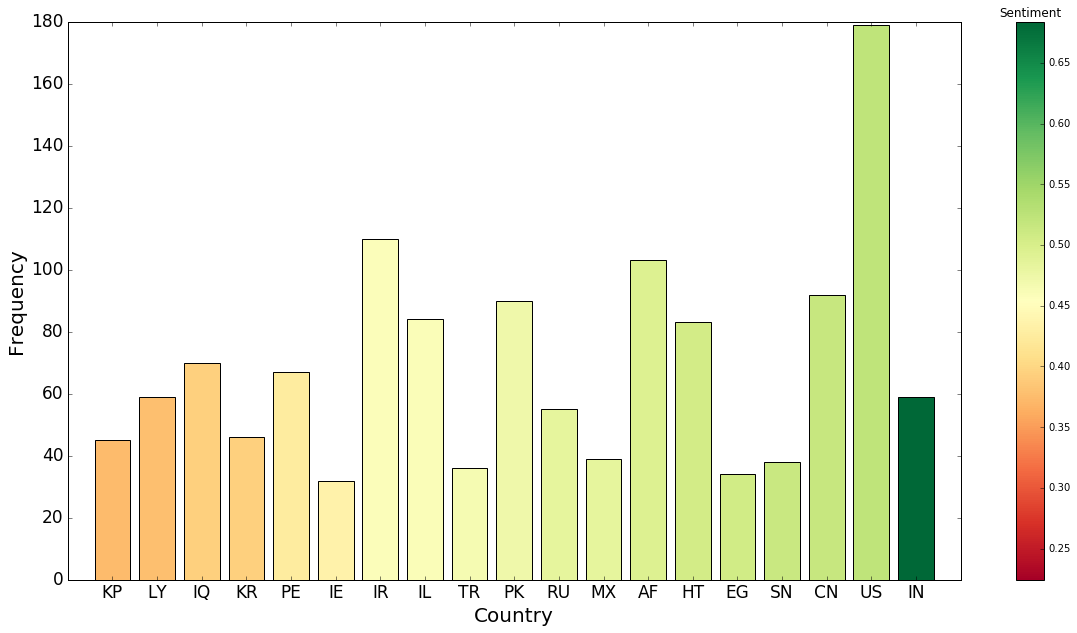

In [130]:
from matplotlib import cm

# Set up colors : red to green
y = np.array(data_country_frequent['polar'])
colors = cm.RdYlGn(y / float(max(y)))
plot = plt.scatter(y, y, c=y, cmap = 'RdYlGn')
plt.clf()
clb = plt.colorbar(plot)
clb.ax.set_title("Sentiment")

# Display bar plot : country frequency vs. country name, with color indicating polarity score
plt.bar(bins, data_country_frequent['count'], align='center', tick_label=data_country_frequent.index, color=colors)
#plt.xticks(rotation=45, ha='right')
plt.xlabel("Country",fontsize = 20)
plt.ylabel("Frequency",fontsize = 20)
plt.rcParams['figure.figsize'] = (20, 10)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)

#### demo_liu_hu_lexicon
First we transform the scores to integers, we set the negetaive score to 0, the neutral score to 0.5, and the positive score to 1.

In [118]:
def thingy(x):
    if x=='Neutral':
        return 0.5
    elif  x=='Negative':
        return 0
    elif x=='Positive':
        return 1
liu_hu_float_score = liu_hu_scores.map(thingy)

In [119]:
average_polar = avg_score(liu_hu_float_score)

In [120]:
# we made a dataframe of the existing information to handle better them
data_country = pd.DataFrame({'name':list(countries_dict.keys())})
data_country['count'] = counts
data_country['polar'] = average_polar
data_country = data_country.sort(['polar'])
data_country = data_country.set_index(['name'])

/Users/salehi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


We decide to keep only the countries who have more than 30 entries.

In [121]:
data_country_frequent = data_country[data_country['count']>30]
data_country_frequent_liu = data_country_frequent

(array([   0.,   20.,   40.,   60.,   80.,  100.,  120.,  140.,  160.,  180.]),
 <a list of 10 Text yticklabel objects>)

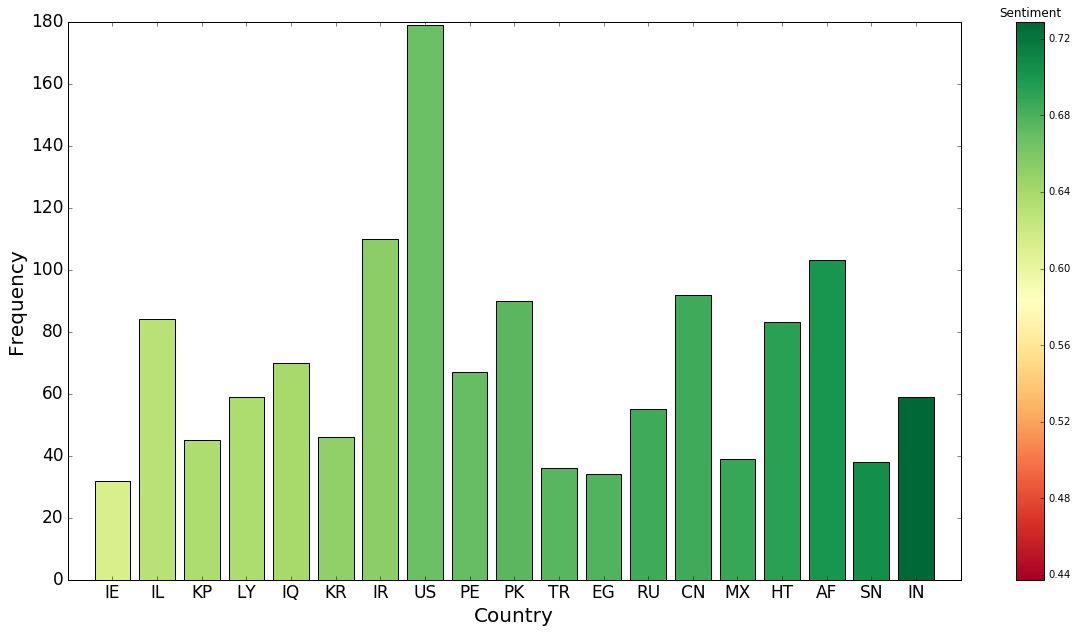

In [123]:
from matplotlib import cm

# Set up colors : red to green
y = np.array(data_country_frequent['polar'])
colors = cm.RdYlGn(y / float(max(y)))
plot = plt.scatter(y, y, c=y, cmap = 'RdYlGn')
plt.clf()
clb = plt.colorbar(plot)
clb.ax.set_title("Sentiment")

# Display bar plot : country frequency vs. country name, with color indicating polarity score
plt.bar(bins, data_country_frequent['count'], align='center', tick_label=data_country_frequent.index, color=colors)
#plt.xticks(rotation=45, ha='right')
plt.xlabel("Country",fontsize = 20)
plt.ylabel("Frequency",fontsize = 20)
plt.rcParams['figure.figsize'] = (20, 10)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)

#### demo_sent_subjectivity:
Here we want to see the subjectivity or objectivity of each country in the corpus. Again we first transform the score them to numbers, subjective to 0 and objective to 1.

In [131]:
def thingy2(x):
    if x=='subj':
        return 0
    elif  x=='obj':
        return 1
sent_sub_float_score = sent_sub_scores.map(thingy2)


In [132]:
average_polar = avg_score(sent_sub_float_score)
# we made a dataframe of the existing information to handle better them
data_country = pd.DataFrame({'name':list(countries_dict.keys())})
data_country['count'] = counts
data_country['polar'] = average_polar
data_country = data_country.sort(['polar'])
data_country = data_country.set_index(['name'])
data_country_frequent = data_country[data_country['count']>30]

/Users/salehi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


(array([   0.,   20.,   40.,   60.,   80.,  100.,  120.,  140.,  160.,  180.]),
 <a list of 10 Text yticklabel objects>)

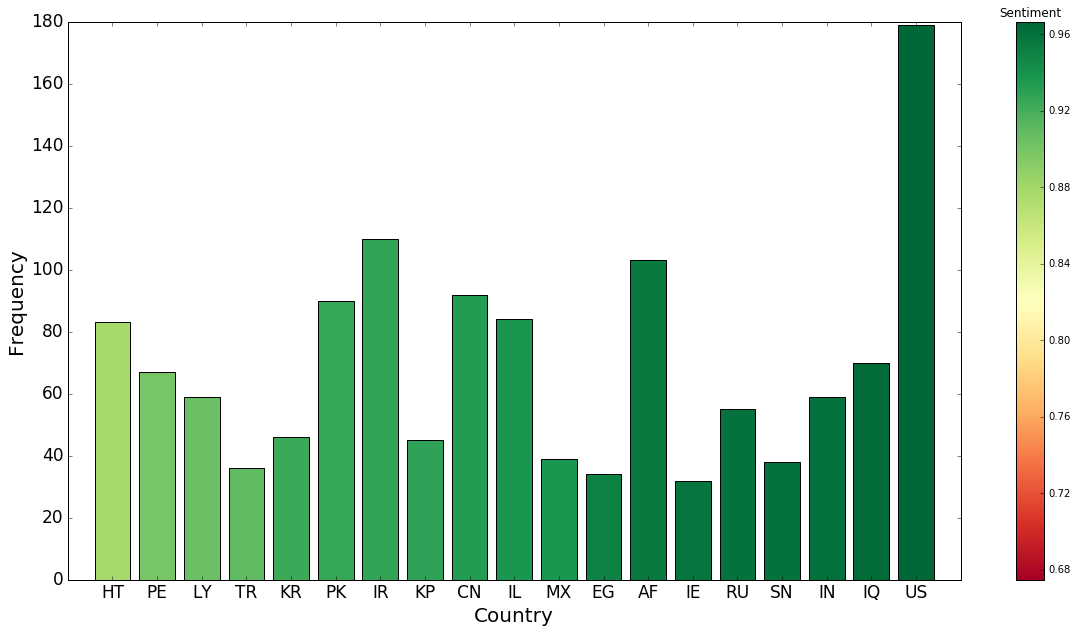

In [134]:
from matplotlib import cm

# Set up colors : red to green
y = np.array(data_country_frequent['polar'])
colors = cm.RdYlGn(y / float(max(y)))
plot = plt.scatter(y, y, c=y, cmap = 'RdYlGn')
plt.clf()
clb = plt.colorbar(plot)
clb.ax.set_title("Sentiment")

# Display bar plot : country frequency vs. country name, with color indicating polarity score
plt.bar(bins, data_country_frequent['count'], align='center', tick_label=data_country_frequent.index, color=colors)
#plt.xticks(rotation=45, ha='right')
plt.xlabel("Country",fontsize = 20)
plt.ylabel("Frequency",fontsize = 20)
plt.rcParams['figure.figsize'] = (20, 10)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)

### What these result say?
Overall, the results of compound score and liu_hu_lexicon seem similar, but with some differences. 
Both give a high score to India and Senegal and low score to North Korea. Interestingly Pakistan is in the middle on both scores, meaning that in both scores Pakistan's score is more than 9 countries and less than 9 countries. Another interesting observation is that if we divide the countries to 2 set, one the countries whose score are more than Pakistan and the other less than Pakistan. The resulting sets for compound and liu_hu_lexicon are similar except one country (see below). However there are differences in the order of the countries.

In [124]:
set(data_country_frequent_liu.index[:10])

{'IE', 'IL', 'IQ', 'IR', 'KP', 'KR', 'LY', 'PE', 'PK', 'US'}

In [125]:
set(data_country_frequent_compound.index[:10])

{'IE', 'IL', 'IQ', 'IR', 'KP', 'KR', 'LY', 'PE', 'PK', 'TR'}

In the subjective and objective score, US is the least objective country in the corpus.